### Import necessary dependencies

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import gc

### Define parameters

In [2]:
BUFFER_SIZE = 400
BATCH_SIZE = 32
IMG_WIDTH = 256
IMG_HEIGHT = 256

PHOTO_FOLDER_PATH = '../small_sketchy_database/256x256/photo/tx_000100000000/'
SKETCH_FOLDER_PATH = '../small_sketchy_database/256x256/sketch/tx_000100000000/'

# The percentage of all photo-sketch image pairs allocated to training (remainder is used for testing).
TRAINING_DATASET_SIZE = 0.9

OUTPUT_CHANNELS = 3

LAMBDA = 100

EPOCHS = 1

### Initialise basic functions

In [3]:
def get_category_names():
    directories = [x[1] for x in os.walk(PHOTO_FOLDER_PATH)]
    non_empty_dirs = [x for x in directories if x]
    return [item for subitem in non_empty_dirs for item in subitem]

In [4]:
def get_file_names(folder_path, category):
    return os.listdir(folder_path + category)

In [5]:
def load_image_pair(photo_file_path, sketch_file_path):
    photo = tf.io.read_file(photo_file_path)
    photo = tf.image.decode_jpeg(photo)
    photo = tf.cast(photo, tf.float32)
    
    sketch = tf.io.read_file(sketch_file_path)
    sketch = tf.image.decode_png(sketch)
    sketch = tf.cast(sketch, tf.float32)
    
    return photo, sketch

### Create training and test datasets

In [6]:
# Define empty arrays that will contain the file paths for all photo and sketch files.
all_photo_file_paths = []
all_sketch_file_paths = []

# Get the category names based on the names of the subfolders in the sketchy database.
category_names = get_category_names()
category_count = 1

# Iterate across each of the category names (e.g. airplane, alarm_clock, ant, etc.)
for category_name in category_names:
    print('[' + str(category_count) + '/' + str(len(category_names)) + '] Loading data for category: ' + category_name)
    
    # Create a list containing all the file names of photos from the current category.
    photo_file_names = get_file_names(PHOTO_FOLDER_PATH, category_name)
    
    # Create a list containing all the file names of sketches from the current category.
    sketch_file_names = get_file_names(SKETCH_FOLDER_PATH, category_name)
    
    # Iterate across each of the photo files.
    for photo_file_name in photo_file_names:
        
        # Define the function that will be used to determine if a sketch file is a pair to the current photo file.
        def filterFunction(file_name):
            if file_name[:-6] == photo_file_name[:-4]:
                return True
            else:
                return False

        # Use the filter function to create a new list containing the file names of sketches that are a pair to the current photo file.
        sketch_pair_file_names = list(filter(filterFunction, sketch_file_names))
        
        for sketch_file_name in sketch_pair_file_names:
            all_photo_file_paths.append(PHOTO_FOLDER_PATH + category_name + '/' + photo_file_name)
            all_sketch_file_paths.append(SKETCH_FOLDER_PATH + category_name + '/' + sketch_file_name)

    category_count += 1

total_image_pairs = len(all_photo_file_paths)
print("Total photo-sketch image pairs: " + str(total_image_pairs))

# Create a combined dataset including the file names of both the photos and sketches.
all_dataset = tf.data.Dataset.from_tensor_slices((all_photo_file_paths, all_sketch_file_paths))

# Shuffle the dataset (batch size is the total number of images so the categories are sufficiently mixed together).
# (Having a smaller batch size, e.g. 400, would only shuffle the first 400 images amongst eachother, then the next 400, etc)
all_dataset = all_dataset.shuffle(total_image_pairs)

# Applies the load_image_pair function to each pair of file names, resulting in the dataset becoming pairs of actual images.
all_dataset = all_dataset.map(load_image_pair, num_parallel_calls=tf.data.experimental.AUTOTUNE)

all_dataset = all_dataset.batch(1)

# Calculate the number of photo-sketch image pairs to allocate to the training dataset based on the supplied parameter.
train_dataset_size = int(round(TRAINING_DATASET_SIZE * total_image_pairs))

# Allocate a percentage of all photo-sketch image pairs into a dataset for training.
print("Creating training dataset with " + str(train_dataset_size) + " image pairs.")
training_dataset = all_dataset.take(train_dataset_size)

# Allocate a percentage of all photo-sketch image pairs into a dataset for training.
print("Creating testing dataset with " + str(total_image_pairs - train_dataset_size) + " image pairs.")
test_dataset = all_dataset.skip(train_dataset_size)

# Show the first 10 image pairs as an example.
# count = 0
# for photo, sketch in training_dataset:
#     print("==== PHOTO ====")
#     print(photo.shape)
#     plt.figure()
#     plt.imshow(photo)
#     plt.figure()
#     plt.imshow(sketch)
#     count += 1
#     if count == 10:
#         break

[1/1] Loading data for category: butterfly
Total photo-sketch image pairs: 24
Creating training dataset with 22 image pairs.
Creating testing dataset with 2 image pairs.


### Build the generator

In [7]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)\
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [8]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [9]:
def Generator():
    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh') # (bs, 256, 256, 3)

    concat = tf.keras.layers.Concatenate()

    inputs = tf.keras.layers.Input(shape=[None,None,3])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [10]:
generator = Generator()

# photo, sketch = load_image_pair(PHOTO_FOLDER_PATH + 'butterfly/n02274259_5263.jpg', SKETCH_FOLDER_PATH + 'butterfly/n02274259_5263-1.png')

# gen_output = generator(photo[tf.newaxis,...], training=False)
# plt.imshow(gen_output[0,...])

### Build the discriminator

In [11]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [12]:
discriminator = Discriminator()

# photo, sketch = load_image_pair(PHOTO_FOLDER_PATH + 'butterfly/n02274259_5263.jpg', SKETCH_FOLDER_PATH + 'butterfly/n02274259_5263-1.png')

# disc_out = discriminator([photo[tf.newaxis,...], gen_output], training=False)
# plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
# plt.colorbar()

### Define the loss functions and the optimizer

In [13]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [14]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [15]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

### Checkpoints (Object-based saving)

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)

### Training

In [18]:
def generate_images(model, test_input, tar):
    # the training=True is intentional here since
    # we want the batch statistics while running the model
    # on the test dataset. If we use training=False, we will get
    # the accumulated statistics learned from the training dataset
    # (which we don't want)
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
        
    plt.show()

In [19]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))


In [20]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        count = 1
        for input_image, target in dataset:
            print("train step " + str(count))
            count += 1
            train_step(input_image, target)

        clear_output(wait=True)
        for inp, tar in test_dataset.take(1):
            generate_images(generator, inp, tar)

        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))


W0512 17:34:34.557456 140715375900480 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 17:34:34.578195 140715375900480 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


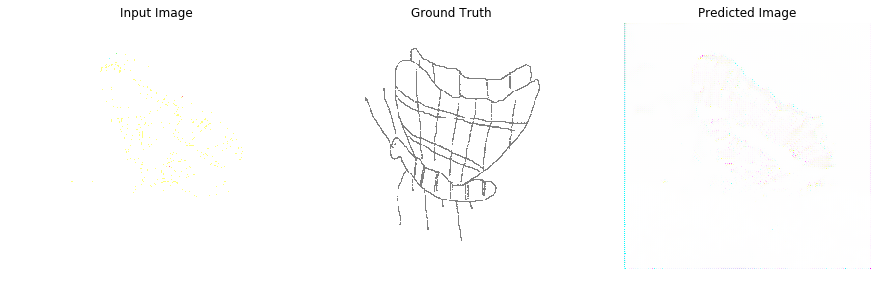

Time taken for epoch 1 is 37.57804560661316 sec



In [21]:
train(training_dataset, EPOCHS)

count: 1
count: 2
count: 3
count: 4
count: 5
count: 6
count: 7
count: 8
count: 9
count: 10
count: 11
count: 12
count: 13
count: 14
count: 15
count: 16
count: 17
count: 18
count: 19
count: 20
count: 21
count: 22


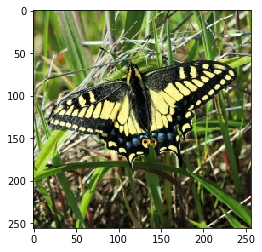

In [43]:
count = 1
for photo, sketch in training_dataset:
    print("count: " + str(count))
    plt.imshow(tf.squeeze(photo/255.0))
    count += 1
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(photo, training=True)

#         disc_real_output = discriminator([photo, sketch], training=True)
#         disc_generated_output = discriminator([photo, sketch], training=True)

#         gen_loss = generator_loss(disc_generated_output, gen_output, photo)
#         disc_loss = discriminator_loss(disc_real_output, disc_generated_output)